# Model

In [1]:
import torch
import torch.nn as nn

c:\Users\Administrator\Documents\1707057\Thesis\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [4]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"

In [6]:
test()

# Utility

In [7]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [8]:
def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [9]:
def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])

# Train

In [10]:
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from tqdm import tqdm

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} for training")

Using cuda for training


In [12]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

In [13]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [14]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
# comment mnist above and uncomment below for training on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [15]:
# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
initialize_weights(gen)
print(gen)

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(32, 1, kernel_si

In [16]:
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(critic)
print(critic)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)


In [17]:
# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

In [18]:
# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

In [19]:
gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [20]:
disc_loss = []
gen_loss = []

In [21]:
for epoch in range(NUM_EPOCHS):
    running_disc_loss = 0.0
    running_gen_loss = 0.0
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

            running_disc_loss += loss_critic.item()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        running_gen_loss += loss_gen.item()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
    
    disc_loss.append(running_disc_loss / len(loader))
    gen_loss.append(running_gen_loss / len(loader)) 

print("Finished Training") 

 11%|█         | 100/938 [00:33<03:55,  3.55it/s]

Epoch [0/5] Batch 100/938                   Loss D: -110.0822, loss G: 61.4911


 21%|██▏       | 201/938 [01:03<04:23,  2.80it/s]

Epoch [0/5] Batch 200/938                   Loss D: -125.6167, loss G: 91.7681


 32%|███▏      | 301/938 [01:42<05:24,  1.96it/s]

Epoch [0/5] Batch 300/938                   Loss D: -117.4831, loss G: 104.7975


 43%|████▎     | 401/938 [02:19<04:00,  2.23it/s]

Epoch [0/5] Batch 400/938                   Loss D: -103.4819, loss G: 99.3672


 53%|█████▎    | 501/938 [02:57<02:54,  2.51it/s]

Epoch [0/5] Batch 500/938                   Loss D: -90.3283, loss G: 90.5599


 64%|██████▍   | 601/938 [03:34<02:15,  2.48it/s]

Epoch [0/5] Batch 600/938                   Loss D: -78.4993, loss G: 94.4410


 75%|███████▍  | 701/938 [04:11<01:35,  2.47it/s]

Epoch [0/5] Batch 700/938                   Loss D: -64.4697, loss G: 80.9262


 85%|████████▌ | 801/938 [04:48<00:55,  2.47it/s]

Epoch [0/5] Batch 800/938                   Loss D: -54.2679, loss G: 78.1705


 96%|█████████▌| 901/938 [05:25<00:16,  2.22it/s]

Epoch [0/5] Batch 900/938                   Loss D: -43.1730, loss G: 74.4785


 11%|█         | 101/938 [00:36<05:40,  2.46it/s]

Epoch [1/5] Batch 100/938                   Loss D: -30.3136, loss G: 73.5575


 21%|██▏       | 200/938 [01:11<04:26,  2.77it/s]

Epoch [1/5] Batch 200/938                   Loss D: -24.7663, loss G: 71.9744


 32%|███▏      | 301/938 [01:48<04:03,  2.62it/s]

Epoch [1/5] Batch 300/938                   Loss D: -18.7246, loss G: 72.4616


 43%|████▎     | 401/938 [02:24<03:33,  2.52it/s]

Epoch [1/5] Batch 400/938                   Loss D: -16.9015, loss G: 66.3518


 53%|█████▎    | 501/938 [03:00<02:59,  2.44it/s]

Epoch [1/5] Batch 500/938                   Loss D: -14.2313, loss G: 73.0837


 64%|██████▍   | 601/938 [03:36<02:14,  2.50it/s]

Epoch [1/5] Batch 600/938                   Loss D: -10.0547, loss G: 71.5987


 75%|███████▍  | 701/938 [04:13<01:34,  2.50it/s]

Epoch [1/5] Batch 700/938                   Loss D: -11.9921, loss G: 63.3711


 85%|████████▌ | 801/938 [04:50<00:54,  2.52it/s]

Epoch [1/5] Batch 800/938                   Loss D: -10.6512, loss G: 73.6889


 96%|█████████▌| 901/938 [05:25<00:14,  2.56it/s]

Epoch [1/5] Batch 900/938                   Loss D: -10.5017, loss G: 68.4054


 11%|█         | 101/938 [00:36<05:44,  2.43it/s]

Epoch [2/5] Batch 100/938                   Loss D: -10.0715, loss G: 74.0833


 21%|██▏       | 201/938 [01:11<04:34,  2.68it/s]

Epoch [2/5] Batch 200/938                   Loss D: -10.1787, loss G: 74.1403


 32%|███▏      | 301/938 [01:48<04:11,  2.53it/s]

Epoch [2/5] Batch 300/938                   Loss D: -10.2454, loss G: 76.5421


 43%|████▎     | 401/938 [02:24<03:36,  2.49it/s]

Epoch [2/5] Batch 400/938                   Loss D: -9.5528, loss G: 75.9174


 53%|█████▎    | 501/938 [03:00<03:13,  2.26it/s]

Epoch [2/5] Batch 500/938                   Loss D: -11.6826, loss G: 78.4100


 64%|██████▍   | 601/938 [03:36<02:08,  2.62it/s]

Epoch [2/5] Batch 600/938                   Loss D: -9.8445, loss G: 77.1349


 75%|███████▍  | 701/938 [04:13<01:35,  2.49it/s]

Epoch [2/5] Batch 700/938                   Loss D: -9.2914, loss G: 77.6599


 85%|████████▌ | 801/938 [04:49<00:53,  2.55it/s]

Epoch [2/5] Batch 800/938                   Loss D: -7.7316, loss G: 75.0225


 96%|█████████▌| 901/938 [05:25<00:14,  2.57it/s]

Epoch [2/5] Batch 900/938                   Loss D: -8.5841, loss G: 71.8406


 11%|█         | 101/938 [00:36<05:37,  2.48it/s]

Epoch [3/5] Batch 100/938                   Loss D: -8.1560, loss G: 76.5299


 21%|██▏       | 201/938 [01:12<04:49,  2.55it/s]

Epoch [3/5] Batch 200/938                   Loss D: -10.1264, loss G: 69.8527


 32%|███▏      | 301/938 [01:49<04:06,  2.58it/s]

Epoch [3/5] Batch 300/938                   Loss D: -8.8344, loss G: 73.5925


 43%|████▎     | 401/938 [02:26<03:31,  2.54it/s]

Epoch [3/5] Batch 400/938                   Loss D: -10.3599, loss G: 76.3533


 53%|█████▎    | 501/938 [03:01<02:44,  2.66it/s]

Epoch [3/5] Batch 500/938                   Loss D: -7.4427, loss G: 74.8132


 64%|██████▍   | 601/938 [03:37<02:12,  2.55it/s]

Epoch [3/5] Batch 600/938                   Loss D: -8.7207, loss G: 76.7749


 75%|███████▍  | 701/938 [04:14<01:31,  2.59it/s]

Epoch [3/5] Batch 700/938                   Loss D: -7.8511, loss G: 76.5282


 85%|████████▌ | 801/938 [04:49<00:49,  2.78it/s]

Epoch [3/5] Batch 800/938                   Loss D: -8.8748, loss G: 73.3369


 96%|█████████▌| 901/938 [05:27<00:14,  2.53it/s]

Epoch [3/5] Batch 900/938                   Loss D: -6.4418, loss G: 75.2092


 11%|█         | 101/938 [00:35<05:47,  2.41it/s]

Epoch [4/5] Batch 100/938                   Loss D: -8.9607, loss G: 77.2780


 21%|██▏       | 201/938 [01:12<04:46,  2.57it/s]

Epoch [4/5] Batch 200/938                   Loss D: -9.4453, loss G: 74.9251


 32%|███▏      | 301/938 [01:47<04:18,  2.46it/s]

Epoch [4/5] Batch 300/938                   Loss D: -9.6438, loss G: 75.2979


 43%|████▎     | 401/938 [02:24<03:27,  2.58it/s]

Epoch [4/5] Batch 400/938                   Loss D: -6.3974, loss G: 74.4180


 53%|█████▎    | 501/938 [03:00<02:47,  2.61it/s]

Epoch [4/5] Batch 500/938                   Loss D: -5.4852, loss G: 75.9000


 64%|██████▍   | 601/938 [03:36<02:08,  2.63it/s]

Epoch [4/5] Batch 600/938                   Loss D: -7.4550, loss G: 76.1235


 75%|███████▍  | 701/938 [04:12<01:32,  2.57it/s]

Epoch [4/5] Batch 700/938                   Loss D: -7.2318, loss G: 76.8221


 85%|████████▌ | 801/938 [04:49<00:50,  2.73it/s]

Epoch [4/5] Batch 800/938                   Loss D: -5.2430, loss G: 79.5058


 96%|█████████▌| 901/938 [05:26<00:14,  2.58it/s]

Epoch [4/5] Batch 900/938                   Loss D: -9.4719, loss G: 77.2068


100%|██████████| 938/938 [05:39<00:00,  2.76it/s]

Finished Training


In [22]:
import matplotlib.pyplot as plt
import numpy as np

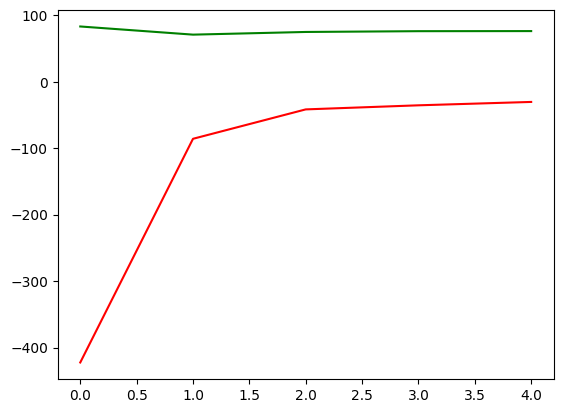

In [23]:
plt.plot(np.array(disc_loss), "r")
plt.plot(np.array(gen_loss), "g")
plt.show()